In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.utils as utils
import torch.utils.data as data
import torchvision.datasets as datasets
import torchvision.transforms as transforms

In [2]:
standardize = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,),(0.5,))])

train_data = datasets.MNIST(root='data/', train=True, transform=standardize, download=False)
test_data = datasets.MNIST(root='data/', train=False, transform=standardize, download=False)

batch_size = 32
# 32가 아니면 train 안 됨
train_dataloader = data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
import numpy as np
from matplotlib import pyplot as plt

def showImg(img):   
    plt.imshow(img)
    plt.show()

torch.Size([1, 50])


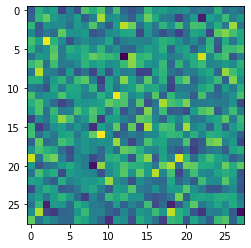

torch.Size([28, 28])


In [4]:
d_noise  = 50
d_hidden = 256

# torch.randn으로 만든 dump data
def fakeImg(batch_size=1, d_noise=50):
    return torch.randn(batch_size, d_noise)

G = nn.Sequential(
    nn.Linear(d_noise, d_hidden),
    nn.ReLU(),
    # nn.Dropout(0.1),
    nn.Linear(d_hidden,d_hidden),
    nn.ReLU(),
    # nn.Dropout(0.1),
    nn.Linear(d_hidden, 28*28),
    nn.Tanh()
).to(device)

# Make Noise
z = fakeImg()
# Put into Generator
print(z.size())
img_fake = G(z).view(1, 28, 28)
# If not .view(1, 28, 28), just bunch of (.784) data
showImg(img_fake.squeeze().detach().numpy())
print(img_fake.squeeze().size())
# If not detach, can't call numpy that requires grad

In [5]:
D = nn.Sequential(
    nn.Linear(28*28, d_hidden),
    nn.LeakyReLU(),
    # nn.Dropout(0.1),
    nn.Linear(d_hidden, d_hidden),
    nn.LeakyReLU(),
    # nn.Dropout(0.1),
    nn.Linear(d_hidden, 1),
    nn.Sigmoid()
    # to use BCELoss
).to(device)
# 왜 LeakyReLU() ?

print(G(z).shape)
print(D(G(z)).shape)
print(D(G(z)).item())

torch.Size([1, 784])
torch.Size([1, 1])
0.49973490834236145


In [6]:
criterion = nn.BCELoss()
def train(G, D, optim_G, optim_D):
    G.train()
    D.train()
    
    for batch, idx in train_dataloader:
        img, label = batch.to(device), idx.to(device)
        
        # optimizer for Discriminator on
        optim_D.zero_grad()
        # reshape해서 28*28 사이즈로 넣어준다
        correct = D(img.view(-1, 28*28))
        wrong = D(G(fakeImg(batch_size, d_noise)))
        # D는 correct일 때, 1에 가깝게 나올 수 있도록 하자
        # D should maxV(D, G) = logD(x) + log(1-D(G(z)))
        # 위 식에서 첫번째 항
        loss_correct = torch.log(correct)
        # 위 식에서 두번째 항
        loss_wrong = torch.log(1.0-wrong)
        # 이 둘을 최대로 만들어야 한다.
        
        # loss를 최소로 하는 방향으로 학습을 진행하므로, -1을 곱해본다.
        # loss_D = (-1)*(loss_correct+loss_wrong)
        # 나중에 .mean 추가해보기
        loss_D = criterion(correct, torch.ones_like(correct).to(device)) + criterion(wrong, torch.zeros_like(wrong).to(device))
        loss_D.backward()
        # grad는 scalar에만 생성이 가능하므로, loss.backward()가 아니라
        # 인자로 loss_D를 backward에 넣어주어야 한다
        optim_D.step()
        # print("loss_D" + str(loss_D))
        
        # optimizer on for Generator
        optim_G.zero_grad()
        # correct는 만들 필요가 없음
        wrong = D(G(fakeImg(batch_size, d_noise)))
        # minV(D, G) = log(1-D(G(z)))
        # loss_G = torch.log(1.0-wrong)
        # loss_G = -1 * torch.log(wrong) #으로 해보기
        loss_G = criterion(wrong, torch.ones_like(wrong).to(device))
        loss_G.backward()
        optim_G.step()
        # print("loss_G" + str(loss_G))
        

In [7]:
def evaluate(G, D):
    correct, wrong = 0.0, 0.0
    G.eval()
    D.eval()
    
    for batch, idx in test_dataloader:
        img, label = batch.to(device), idx.to(device)
        
        with torch.autograd.no_grad():
            correct += (torch.sum(D(img.view(-1, 28*28))).item())
            wrong += (torch.sum(D(G(fakeImg(batch_size, d_noise)))).item())
            # 왜 10000.0으로 나눠야할까
    return correct, wrong

(epoch 4/40) correct: 8649.272795, generated: 590.483088


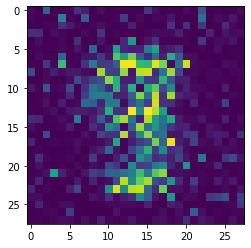

(epoch 8/40) correct: 8330.525119, generated: 1446.741140


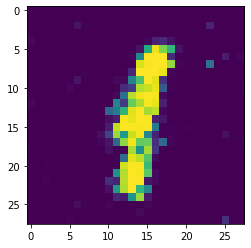

(epoch 12/40) correct: 7545.703691, generated: 2851.131676


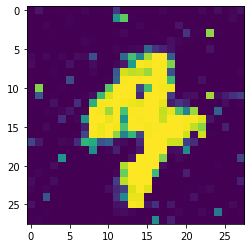

(epoch 16/40) correct: 6801.999426, generated: 2320.839891


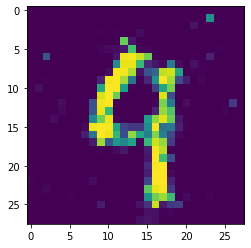

(epoch 20/40) correct: 6897.340614, generated: 3277.636815


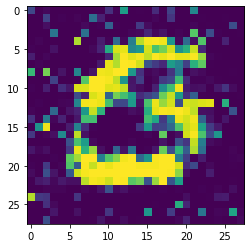

(epoch 24/40) correct: 6837.912422, generated: 2915.153992


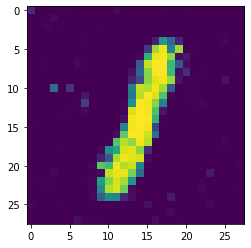

(epoch 28/40) correct: 6772.930270, generated: 2823.762020


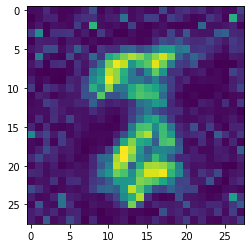

(epoch 32/40) correct: 6837.237473, generated: 2944.073407


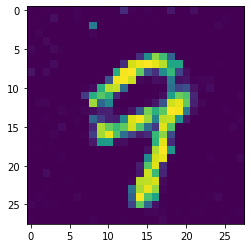

(epoch 36/40) correct: 6080.989179, generated: 2307.900771


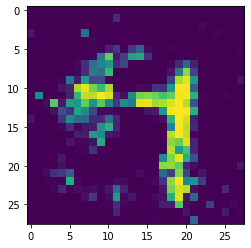

(epoch 40/40) correct: 6684.252382, generated: 2620.919647


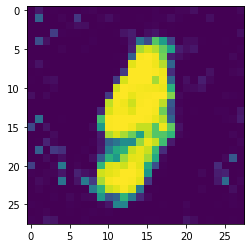

In [8]:
"""
def init_params(model):
    for p in model.parameters():
        if(p.dim() > 1):
            nn.init.xavier_normal_(p)
        else:
            nn.init.uniform_(p, 0.1, 0.2)

init_params(G)
init_params(D)
"""

# lr=0.1, lr=0.01 tried
optim_G = optim.Adam(G.parameters(), lr=0.001)
optim_D = optim.Adam(D.parameters(), lr=0.001)

for epoch in range(40):

    train(G, D, optim_G, optim_D)
    correct, wrong = evaluate(G,D)
    
    correct_trace= []
    wrong_trace = []
    correct_trace.append(correct/10000.0)
    wrong_trace.append(wrong/10000.0)

    if((epoch+1)% 4 == 0):
        print('(epoch %i/40) correct: %f, generated: %f' % (epoch+1, correct, wrong))
        z = fakeImg()
        img_fake = G(z).view(1, 28, 28)
        showImg(img_fake.squeeze().detach())
        

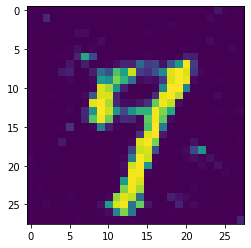

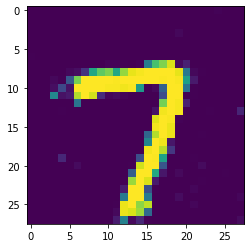

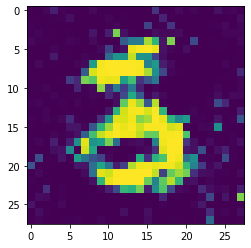

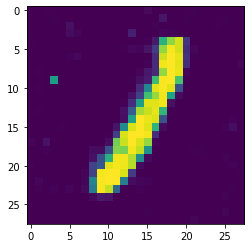

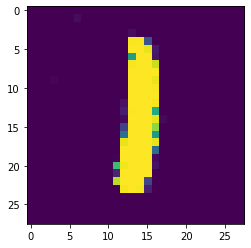

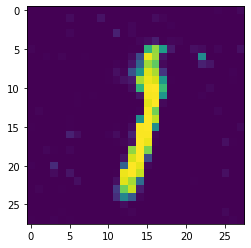

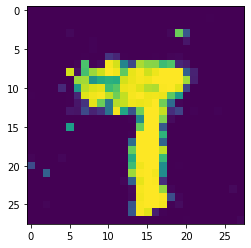

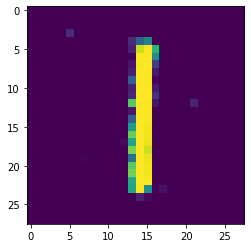

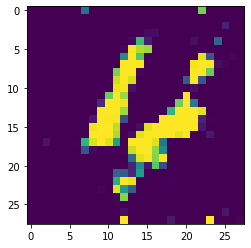

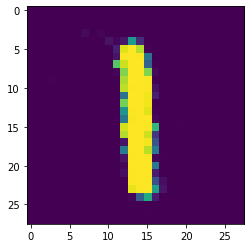

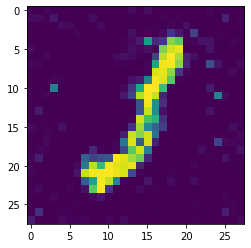

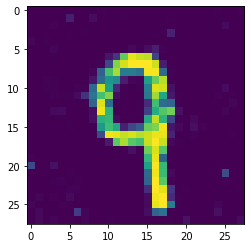

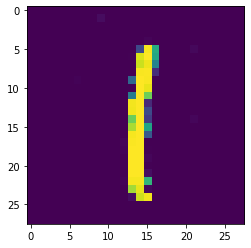

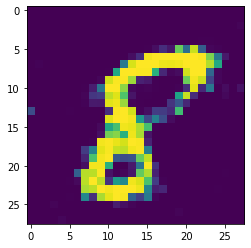

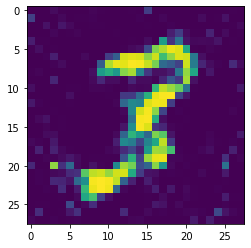

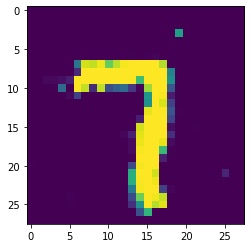

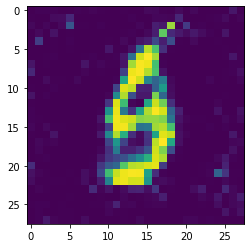

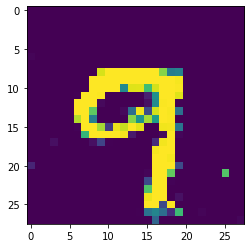

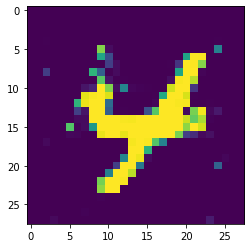

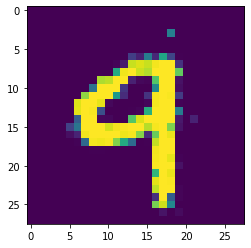

In [10]:
for i in range(20):
    z = fakeImg()
    img_fake = G(z).view(1, 28, 28)
    showImg(img_fake.squeeze().detach())